# Práctica 1

## Importaciones

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
#from pyspark.sql.functions import col

## Inicio de sesión en Spark

In [5]:
# Inicio de la sesión de Spark.
spark = SparkSession.builder \
    .appName("MarathonRegression") \
    .getOrCreate()

## Visualización inicial de los datos

### Carga del dataset

In [6]:
# Cargar el dataset.
df = spark.read.csv(r"C:\Users\Usuario\Desktop\ALEX\GCED\7º cuatri\aprendizaje automático a gran escala\run_ww_2020_d.csv", header=True, inferSchema=True)

### Muestra de las cinco primeras filas y del esquema

In [7]:
# Mostrar las cinco primeras filas.
df.show(5, truncate=False)

# Mostrar esquema de columnas.
df.printSchema()

+---+----------+-------+--------+------------------+------+---------+--------------+-----------------------+
|_c0|datetime  |athlete|distance|duration          |gender|age_group|country       |major                  |
+---+----------+-------+--------+------------------+------+---------+--------------+-----------------------+
|0  |2020-01-01|0      |0.0     |0.0               |F     |18 - 34  |United States |CHICAGO 2019           |
|1  |2020-01-01|1      |5.72    |31.633333333333333|M     |35 - 54  |Germany       |BERLIN 2016            |
|2  |2020-01-01|2      |0.0     |0.0               |M     |35 - 54  |United Kingdom|LONDON 2018,LONDON 2019|
|3  |2020-01-01|3      |0.0     |0.0               |M     |18 - 34  |United Kingdom|LONDON 2017            |
|4  |2020-01-01|4      |8.07    |38.61666666666667 |M     |35 - 54  |United States |BOSTON 2017            |
+---+----------+-------+--------+------------------+------+---------+--------------+-----------------------+
only showing top 5 

### Muestra de filas y variables y principales estadísticas del dataset

In [8]:
# Número de filas y variables.
print(f"Filas: {df.count()}, Variables: {len(df.columns)}")

# Estadísticas descriptivas de variables numéricas.
df.describe(['distance', 'duration']).show()

# Distribución por género y grupo de edad.
df.groupBy("gender").count().show()
df.groupBy("age_group").count().show()

Filas: 13326792, Variables: 9
+-------+-----------------+------------------+
|summary|         distance|          duration|
+-------+-----------------+------------------+
|  count|         13326792|          13326792|
|   mean|3.864718473881684| 21.39197543564929|
| stddev|6.661547347662435| 39.27358918572176|
|    min|              0.0|               0.0|
|    max|           347.95|2299.9666666666667|
+-------+-----------------+------------------+

+------+--------+
|gender|   count|
+------+--------+
|     F| 3253374|
|     M|10073418|
+------+--------+

+---------+-------+
|age_group|  count|
+---------+-------+
|     55 +| 940254|
|  35 - 54|7905966|
|  18 - 34|4480572|
+---------+-------+



## Preparación del dataset

### Filtrado de filas

Como tenemos un gran número de filas, vamos a filtrar. Primero, nos quedamos solo con los registros que no estén vacíos, es decir, aquellos cuya duración y distancia sea mayor a 0.

In [9]:
# Filtrado de filas.
df_filtered = df.filter((df.duration > 0) & (df.distance > 0))

# Comprobar tamaño.
print(f"Filas tras filtrar: {df_filtered.count()}")

Filas tras filtrar: 4581764


### Eliminamos las filas con valores nulos.

In [10]:
df_filtered = df_filtered.dropna()

Como seguimos teniendo gran número de filas, volvemos a filtrar. Ahora vamos a filtrar por número de atletas. Inicialmente tenemos 36.7k atletas. Vamos a probar con cuantos nos quedamos con el número de filas más adecuado.

In [11]:
# Filtrar atletas con ID < 5000.
df_filtered_5000 = df_filtered.filter(df_filtered.athlete < 5000)
print(f"Filas con athlete < 5000: {df_filtered_5000.count()}")

# Filtrar atletas con ID < 8000.
df_filtered_8000 = df_filtered.filter(df_filtered.athlete < 8000)
print(f"Filas con athlete < 8000: {df_filtered_8000.count()}")

# Filtrar atletas con ID < 10000.
df_filtered_10000 = df_filtered.filter(df_filtered.athlete < 10000)
print(f"Filas con athlete < 10000: {df_filtered_10000.count()}")

# Filtrar atletas con ID < 15000.
df_final = df_filtered.filter(df_filtered.athlete < 15000)
print(f"Filas con athlete < 15000: {df_final.count()}")

# Filtrar atletas con ID < 20000.
df_filtered_20000 = df_filtered.filter(df_filtered.athlete < 20000)
print(f"Filas con athlete < 20000: {df_filtered_20000.count()}")

Filas con athlete < 5000: 625635
Filas con athlete < 8000: 996749
Filas con athlete < 10000: 1249180
Filas con athlete < 15000: 1869208
Filas con athlete < 20000: 2471216


Nos quedamos con 15000 atletas, ya que creemos que es el valor más adecuado para lograr un equilibrio entre cantidad para un correcto aprendizaje y velocidad de procesamiento. 

### Creación de la variable "season" a partir de la variable datetime

In [12]:
df_final = df_final.withColumn(
    "season",
    when((month("datetime") >= 3) & (month("datetime") <= 5), "spring")
    .when((month("datetime") >= 6) & (month("datetime") <= 8), "summer")
    .when((month("datetime") >= 9) & (month("datetime") <= 11), "autumn")
    .otherwise("winter"))

### Seleccionamos solo las columnas relevantes

In [13]:
# Seleccionamos las columnas que no son datetime o major.
df_final = df_final.select("athlete", "distance", "duration", "gender", "age_group", "country", "season")

### Muestra de las cinco primeras filas y del esquema del dataset final 

In [14]:
# Mostrar las cinco primeras filas.
df_final.show(5, truncate=False)

# Mostrar esquema de columnas.
df_final.printSchema()

+-------+--------+------------------+------+---------+--------------+------+
|athlete|distance|duration          |gender|age_group|country       |season|
+-------+--------+------------------+------+---------+--------------+------+
|1      |5.72    |31.633333333333333|M     |35 - 54  |Germany       |winter|
|4      |8.07    |38.61666666666667 |M     |35 - 54  |United States |winter|
|5      |10.09   |43.56666666666667 |F     |35 - 54  |United States |winter|
|6      |9.82    |50.53333333333333 |M     |55 +     |United States |winter|
|8      |10.05   |59.05             |M     |35 - 54  |United Kingdom|winter|
+-------+--------+------------------+------+---------+--------------+------+
only showing top 5 rows
root
 |-- athlete: integer (nullable = true)
 |-- distance: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- age_group: string (nullable = true)
 |-- country: string (nullable = true)
 |-- season: string (nullable = false)



### Muestra de filas y variables y principales estadísticas del dataset final

In [15]:
# Número de filas y variables.
print(f"Filas: {df_final.count()}, Variables: {len(df_final.columns)}")

# Estadísticas descriptivas de variables numéricas.
df_final.describe(['distance', 'duration']).show()

# Distribución por género, grupo de edad y estación.
df_final.groupBy("gender").count().show()
df_final.groupBy("age_group").count().show()
df_final.groupBy("season").count().show()

Filas: 1869208, Variables: 7
+-------+-----------------+--------------------+
|summary|         distance|            duration|
+-------+-----------------+--------------------+
|  count|          1869208|             1869208|
|   mean| 11.3417861425814|   62.65104727956109|
| stddev|6.851907901598776|   44.45724057163195|
|    min|             0.01|0.016666666666666666|
|    max|           263.37|              2202.0|
+-------+-----------------+--------------------+

+------+-------+
|gender|  count|
+------+-------+
|     F| 463958|
|     M|1405250|
+------+-------+

+---------+-------+
|age_group|  count|
+---------+-------+
|     55 +| 138448|
|  35 - 54|1117572|
|  18 - 34| 613188|
+---------+-------+

+------+------+
|season| count|
+------+------+
|winter|458894|
|spring|507774|
|summer|473599|
|autumn|428941|
+------+------+



## Preparación de los datos para el entrenamiento

### Convertimos los datos categóricos en vectores one-hot.

In [16]:
# Convertimos las columnas de tipo categórico en índices numéricos. 
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
age_indexer = StringIndexer(inputCol="age_group", outputCol="age_index")
country_indexer = StringIndexer(inputCol="country", outputCol="country_index")
season_indexer = StringIndexer(inputCol="season", outputCol="season_index")

# Convertimos los índices numéricos del paso anterior en vectores one-hot.
encoder = OneHotEncoder(inputCols=["gender_index", "age_index", "country_index", "season_index"],
                        outputCols=["gender_vec", "age_vec", "country_vec", "season_vec"])

### Combinamos las columnas numéricas en un solo vector.

In [17]:
# Creamos un vector features que combine todas las variables numéricas.
assembler = VectorAssembler(inputCols=["distance", "gender_vec", "age_vec", "country_vec", "season_vec"],
                            outputCol="features")


### Creamos un pipeline para aplicar todas las transformaciones

In [18]:
# Creamos el Pipeline con todas las etapas.
pipeline = Pipeline(stages=[gender_indexer, age_indexer, country_indexer, season_indexer, encoder, assembler])

# Ajustamos el pipeline y transformamos los datos.
df_prepared = pipeline.fit(df_final).transform(df_final)

### División de los datos en entrenamiento y test

In [20]:
# Obtenemos los atletas.
athletes = df_final.select("athlete").distinct()

# Asignamos aleatoriamente el 80% de atletas a train y el 20% a test.
train_athletes, test_athletes = athletes.randomSplit([0.8, 0.2], seed=42)

# Filtramos filas según atletas asignados.
train_df = df_prepared.join(train_athletes, on="athlete", how="inner")
test_df = df_prepared.join(test_athletes, on="athlete", how="inner")

# Mostramos el número de filas en train y test.
print(f"Train: {train_df.count()} filas, Test: {test_df.count()} filas")

Train: 1501617 filas, Test: 367591 filas


## Creación de los modelos

### Modelo Regresión Lineal

In [21]:
# Definir la columna objetivo
df_model = df_prepared.withColumnRenamed("duration", "label")

In [22]:

# Asegurarnos de que la columna 'label' existe
train_df = train_df.withColumnRenamed("duration", "label")
test_df = test_df.withColumnRenamed("duration", "label")

# Crear el modelo de regresión lineal
lr = LinearRegression(featuresCol="features", labelCol="label")

# Entrenar el modelo
lr_model = lr.fit(train_df)

# Generar predicciones sobre el conjunto de test
lr_predictions = lr_model.transform(test_df)

# Evaluador para regresión
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

# Calcular métricas
rmse = evaluator.setMetricName("rmse").evaluate(lr_predictions)
r2 = evaluator.setMetricName("r2").evaluate(lr_predictions)

# Mostrar resultados
print("=== Linear Regression ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# (Opcional) Mostrar algunas predicciones reales vs. predichas
lr_predictions.select("athlete", "label", "prediction").show(10, truncate=False)


=== Linear Regression ===
RMSE: 20.11
R²: 0.7978
+-------+------------------+------------------+
|athlete|label             |prediction        |
+-------+------------------+------------------+
|833    |64.73333333333333 |82.2859988280031  |
|1591   |45.11666666666667 |51.30823525596566 |
|4900   |28.983333333333334|26.574000893079244|
|5518   |57.45             |70.54505450154033 |
|7754   |31.416666666666668|30.559500330691186|
|7982   |75.0              |78.00097410056401 |
|10623  |107.0             |128.93111309736972|
|11141  |48.25             |51.24856607857893 |
|833    |43.516666666666666|48.93665302461811 |
|1829   |26.566666666666666|18.062433998574065|
+-------+------------------+------------------+
only showing top 10 rows


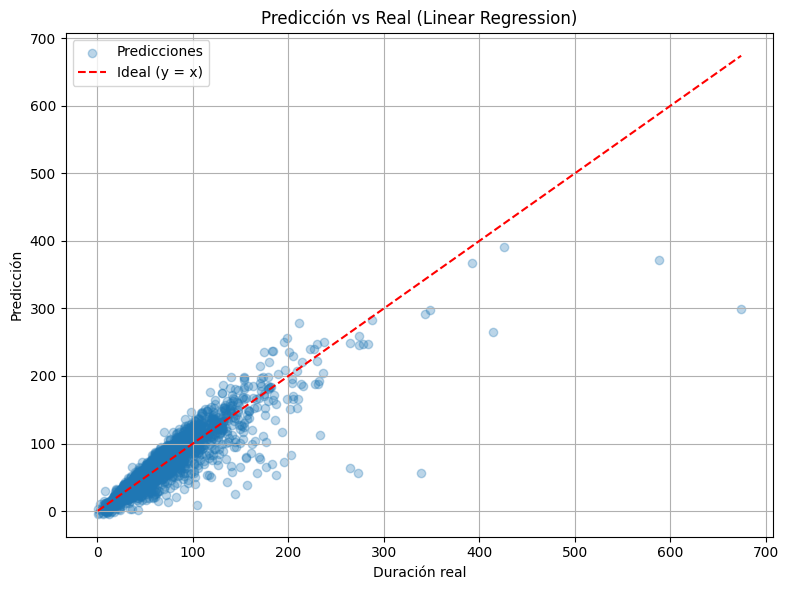

In [23]:
import matplotlib.pyplot as plt
# Muestra pequeña para visualización (ej. 1% del total)
sample_pd = lr_predictions.select("label", "prediction").sample(False, 0.01, seed=42).toPandas()

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(sample_pd["label"], sample_pd["prediction"], alpha=0.3, label="Predicciones")
plt.plot([sample_pd["label"].min(), sample_pd["label"].max()],
         [sample_pd["label"].min(), sample_pd["label"].max()],
         'r--', label="Ideal (y = x)")

plt.xlabel("Duración real")
plt.ylabel("Predicción")
plt.title("Predicción vs Real (Linear Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Modelo de regresión basado en árboles de decisión

In [24]:


# Crear el modelo de árbol de decisión
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label")

# Entrenar el modelo
dt_model = dt.fit(train_df)

# Generar predicciones sobre el conjunto de test
dt_predictions = dt_model.transform(test_df)

# Evaluar el modelo
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

rmse = evaluator.setMetricName("rmse").evaluate(dt_predictions)
r2 = evaluator.setMetricName("r2").evaluate(dt_predictions)

# Mostrar resultados
print("=== Decision Tree Regressor ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Mostrar algunas predicciones
dt_predictions.select("athlete", "label", "prediction").show(10, truncate=False)

=== Decision Tree Regressor ===
RMSE: 26.46
R²: 0.6499
+-------+------------------+------------------+
|athlete|label             |prediction        |
+-------+------------------+------------------+
|833    |64.73333333333333 |79.52010690292384 |
|1591   |45.11666666666667 |53.13355800639574 |
|4900   |28.983333333333334|30.149521838757966|
|5518   |57.45             |71.4336685376765  |
|7754   |31.416666666666668|30.149521838757966|
|7982   |75.0              |71.4336685376765  |
|10623  |107.0             |124.76207006583365|
|11141  |48.25             |49.727838529813354|
|833    |43.516666666666666|44.88795784411153 |
|1829   |26.566666666666666|30.149521838757966|
+-------+------------------+------------------+
only showing top 10 rows


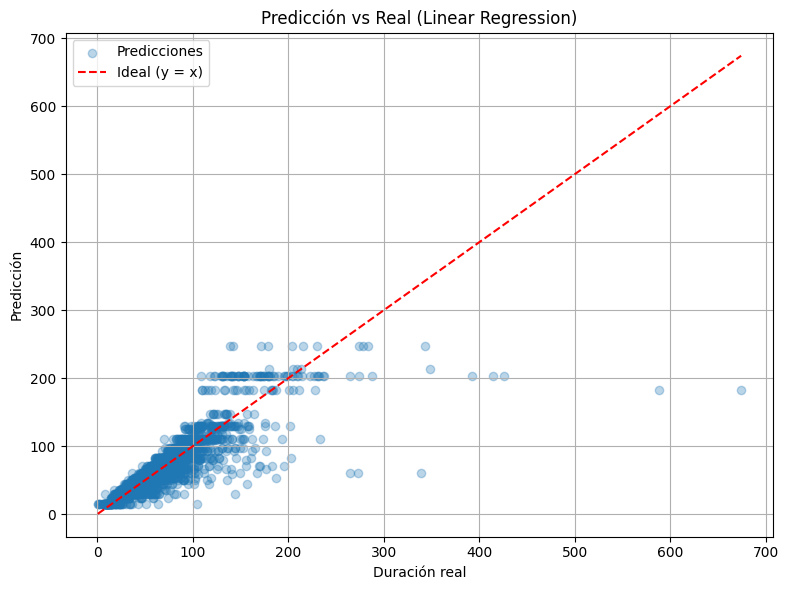

In [25]:
import matplotlib.pyplot as plt
# Muestra pequeña para visualización (ej. 1% del total)
sample_pd = dt_predictions.select("label", "prediction").sample(False, 0.01, seed=42).toPandas()

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(sample_pd["label"], sample_pd["prediction"], alpha=0.3, label="Predicciones")
plt.plot([sample_pd["label"].min(), sample_pd["label"].max()],
         [sample_pd["label"].min(), sample_pd["label"].max()],
         'r--', label="Ideal (y = x)")

plt.xlabel("Duración real")
plt.ylabel("Predicción")
plt.title("Predicción vs Real (Linear Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Modelo de regresión basado en un bosque aleatorio de árboles de decisión

In [26]:
# Crear el modelo de Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=70, maxDepth=8, seed=42)

# Entrenar el modelo
rf_model = rf.fit(train_df)

# Generar predicciones sobre el conjunto de test
rf_predictions = rf_model.transform(test_df)

# Evaluador
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

# Calcular métricas
rmse = evaluator.setMetricName("rmse").evaluate(rf_predictions)
r2 = evaluator.setMetricName("r2").evaluate(rf_predictions)

# Mostrar resultados
print("=== Random Forest Regressor ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Mostrar algunas predicciones
rf_predictions.select("athlete", "label", "prediction").show(10, truncate=False)

=== Random Forest Regressor ===
RMSE: 27.23
R²: 0.6291
+-------+------------------+------------------+
|athlete|label             |prediction        |
+-------+------------------+------------------+
|833    |64.73333333333333 |71.75458827173324 |
|1591   |45.11666666666667 |56.073230826871   |
|4900   |28.983333333333334|35.445789152369215|
|5518   |57.45             |68.10907442593765 |
|7754   |31.416666666666668|36.3120710374907  |
|7982   |75.0              |73.4270050229524  |
|10623  |107.0             |132.6564832950166 |
|11141  |48.25             |46.70672721577312 |
|833    |43.516666666666666|46.19105979066794 |
|1829   |26.566666666666666|35.371355210415985|
+-------+------------------+------------------+
only showing top 10 rows


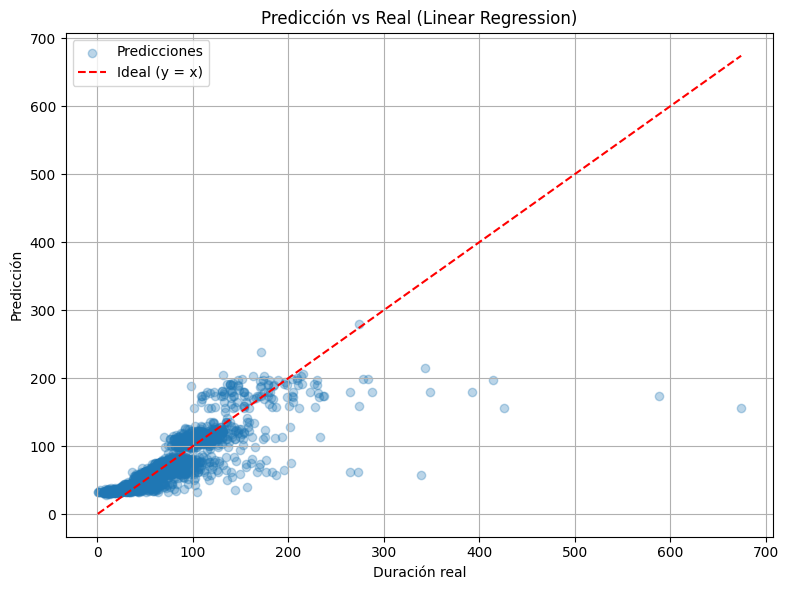

In [27]:
import matplotlib.pyplot as plt
# Muestra pequeña para visualización (ej. 1% del total)
sample_pd = rf_predictions.select("label", "prediction").sample(False, 0.01, seed=42).toPandas()

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(sample_pd["label"], sample_pd["prediction"], alpha=0.3, label="Predicciones")
plt.plot([sample_pd["label"].min(), sample_pd["label"].max()],
         [sample_pd["label"].min(), sample_pd["label"].max()],
         'r--', label="Ideal (y = x)")

plt.xlabel("Duración real")
plt.ylabel("Predicción")
plt.title("Predicción vs Real (Linear Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Busqueda de hiperparametros

In [28]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression

# Evaluador propio
evaluator_lr = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Modelo base
lr = LinearRegression(featuresCol="features", labelCol="label", maxIter=50)

# Grid propio
lr_grid = (ParamGridBuilder()
           .addGrid(lr.regParam, [0.0, 0.01, 0.1])
           .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # Ridge / Mixto / Lasso
           .build())

# CV propio
lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lr_grid,
    evaluator=evaluator,
    numFolds=3,              # baja de 5/10 a 3
    parallelism=1,           # ¡clave para no reventar memoria!
    seed=42,
    collectSubModels=False   # evita guardar todos los submodelos
)


print("CV -> LinearRegression")
lr_cv_model = lr_cv.fit(train_df)

# Evaluación test
lr_preds = lr_cv_model.transform(test_df).cache()
lr_rmse  = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse").evaluate(lr_preds)
lr_r2    = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(lr_preds)

# Mejores hiperparámetros
best_lr = lr_cv_model.bestModel
best_lr_params = {p.name: best_lr.getOrDefault(p) for p in best_lr.extractParamMap()}

print(f"[LR] RMSE: {lr_rmse:.4f} | R2: {lr_r2:.4f}")
print("[LR] Mejores hiperparámetros:", {k: best_lr_params[k] for k in ["regParam","elasticNetParam","maxIter"] if k in best_lr_params})

# (Opcional) Coeficientes
print("[LR] #Coef:", len(best_lr.coefficients))


CV -> LinearRegression
[LR] RMSE: 20.1070 | R2: 0.7978
[LR] Mejores hiperparámetros: {'regParam': 0.0, 'elasticNetParam': 0.0, 'maxIter': 50}
[LR] #Coef: 113


In [29]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor

# Evaluador propio
evaluator_dt = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Modelo base
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label", seed=42)

# Grid propio
dt_grid = (ParamGridBuilder()
           .addGrid(dt.maxDepth, [5, 10, 15])
           .addGrid(dt.minInstancesPerNode, [1, 5, 20])
           .build())

# CV propio
dt_cv = CrossValidator(
    estimator=dt,
    estimatorParamMaps=dt_grid,
    evaluator=evaluator_dt,
    numFolds=3,
    parallelism=2,
    seed=42
)

print("CV -> DecisionTree")
dt_cv_model = dt_cv.fit(train_df)

# Evaluación test
dt_preds = dt_cv_model.transform(test_df).cache()
dt_rmse  = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse").evaluate(dt_preds)
dt_r2    = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(dt_preds)

# Mejores hiperparámetros
best_dt = dt_cv_model.bestModel
best_dt_params = {
    "maxDepth": best_dt.getOrDefault(best_dt.maxDepth),
    "minInstancesPerNode": best_dt.getOrDefault(best_dt.minInstancesPerNode)
}

print(f"[DT] RMSE: {dt_rmse:.4f} | R2: {dt_r2:.4f}")
print("[DT] Mejores hiperparámetros:", best_dt_params)

# (Opcional) Importancias no aplican; es un árbol único. Puedes inspeccionar la profundidad:
print("[DT] Profundidad:", best_dt.depth)


CV -> DecisionTree


Py4JJavaError: An error occurred while calling o12191.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 163 in stage 1034.0 failed 1 times, most recent failure: Lost task 163.0 in stage 1034.0 (TID 94128) (10.20.35.131 executor driver): java.lang.OutOfMemoryError: Java heap space
	at net.jpountz.lz4.LZ4BlockOutputStream.<init>(LZ4BlockOutputStream.java:102)
	at org.apache.spark.io.LZ4CompressionCodec.compressedOutputStream(CompressionCodec.scala:151)
	at org.apache.spark.serializer.SerializerManager.wrapForCompression(SerializerManager.scala:159)
	at org.apache.spark.serializer.SerializerManager.wrapStream(SerializerManager.scala:134)
	at org.apache.spark.shuffle.ShufflePartitionPairsWriter.open(ShufflePartitionPairsWriter.scala:76)
	at org.apache.spark.shuffle.ShufflePartitionPairsWriter.write(ShufflePartitionPairsWriter.scala:60)
	at org.apache.spark.util.collection.WritablePartitionedIterator.writeNext(WritablePartitionedPairCollection.scala:83)
	at org.apache.spark.util.collection.ExternalSorter.$anonfun$writePartitionedMapOutput$1(ExternalSorter.scala:718)
	at org.apache.spark.util.collection.ExternalSorter$$Lambda$5957/0x0000028ea8486ce8.apply$mcV$sp(Unknown Source)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.util.collection.ExternalSorter.writePartitionedMapOutput(ExternalSorter.scala:721)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:70)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$3081/0x0000028ea7eaaf08.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:740)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:739)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:665)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:210)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:304)
	at org.apache.spark.ml.regression.DecisionTreeRegressor.$anonfun$train$1(DecisionTreeRegressor.scala:137)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:226)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:226)
	at org.apache.spark.ml.regression.DecisionTreeRegressor.train(DecisionTreeRegressor.scala:117)
	at org.apache.spark.ml.regression.DecisionTreeRegressor.train(DecisionTreeRegressor.scala:47)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:115)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at net.jpountz.lz4.LZ4BlockOutputStream.<init>(LZ4BlockOutputStream.java:102)
	at org.apache.spark.io.LZ4CompressionCodec.compressedOutputStream(CompressionCodec.scala:151)
	at org.apache.spark.serializer.SerializerManager.wrapForCompression(SerializerManager.scala:159)
	at org.apache.spark.serializer.SerializerManager.wrapStream(SerializerManager.scala:134)
	at org.apache.spark.shuffle.ShufflePartitionPairsWriter.open(ShufflePartitionPairsWriter.scala:76)
	at org.apache.spark.shuffle.ShufflePartitionPairsWriter.write(ShufflePartitionPairsWriter.scala:60)
	at org.apache.spark.util.collection.WritablePartitionedIterator.writeNext(WritablePartitionedPairCollection.scala:83)
	at org.apache.spark.util.collection.ExternalSorter.$anonfun$writePartitionedMapOutput$1(ExternalSorter.scala:718)
	at org.apache.spark.util.collection.ExternalSorter$$Lambda$5957/0x0000028ea8486ce8.apply$mcV$sp(Unknown Source)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.util.collection.ExternalSorter.writePartitionedMapOutput(ExternalSorter.scala:721)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:70)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$3081/0x0000028ea7eaaf08.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

# Evaluador propio
evaluator_rf = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Modelo base
rf = RandomForestRegressor(featuresCol="features", labelCol="label", seed=42)

# Grid propio
rf_grid = (ParamGridBuilder()
           .addGrid(rf.numTrees, [50, 100])
           .addGrid(rf.maxDepth, [8, 12])
           .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt"])
           .build())

# CV propio
rf_cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=rf_grid,
    evaluator=evaluator_rf,
    numFolds=3,
    parallelism=2,
    seed=42
)

print("CV -> RandomForest")
rf_cv_model = rf_cv.fit(train_df)

# Evaluación test
rf_preds = rf_cv_model.transform(test_df).cache()
rf_rmse  = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse").evaluate(rf_preds)
rf_r2    = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(rf_preds)

# Mejores hiperparámetros
best_rf = rf_cv_model.bestModel
best_rf_params = {
    "numTrees": best_rf.getNumTrees,
    "maxDepth": best_rf.getOrDefault(best_rf.maxDepth),
    "featureSubsetStrategy": best_rf.getOrDefault(best_rf.featureSubsetStrategy),
}

print(f"[RF] RMSE: {rf_rmse:.4f} | R2: {rf_r2:.4f}")
print("[RF] Mejores hiperparámetros:", best_rf_params)

# (Opcional) Importancias
print("[RF] Top-10 importancias:", list(best_rf.featureImportances.toArray())[:10])
